In [42]:
%reload_ext autoreload
%autoreload 2

import pickle
import time as tt
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
from constants import G, KPC_TO_KM, GYR_TO_S
from utils import get_track, get_q

## First, start by defining the paramters

In [43]:
# Flattened NFW halo
logM, Rs, q = 12.0, 25.0, 0.8
dirx, diry, dirz = 1., 1., 1. #1.0, 1.0, 1.0

# Plummer Sattelite
logm, rs = 8.0, 2.0 

# Initial conditions
x0, y0, z0 = 100.0, 0.0, 0.0     # Position in kpc
vx0, vy0, vz0 = 0.0, 200.0, 0.0  # Velocity in kpc/Gyr

# Integration time
time = 4. # Gyr
alpha = 1.

params = (logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha)

## (1) Spray Method

In [6]:
from spray import generate_stream_spray

start = tt.time()
theta_stream_spray, xv_stream_spray, theta_sat_spray, xv_sat_spray = generate_stream_spray(params,  111)
end = tt.time()
print(f"Time taken to generate stream using Spray: {end - start:.2f} seconds")
count_spray, theta_bin_spray, r_bin_spray, w_bin_spray = get_track(theta_stream_spray, xv_stream_spray[:, 0], xv_stream_spray[:, 1])

2025-09-02 15:20:38.283292: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_generate_stream_spray] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-09-02 15:20:51.769877: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m13.48982s

********************************
[Compiling module jit_generate_stream_spray] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Time taken to generate stream using Spray: 149.63 seconds


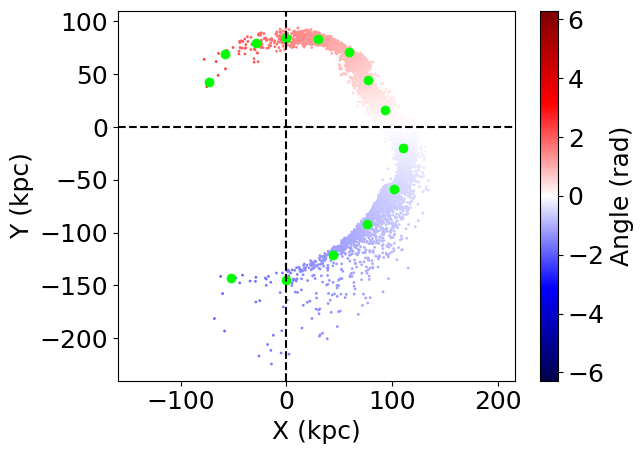

In [233]:
plt.scatter(xv_stream_spray[:, 0], xv_stream_spray[:, 1], c=theta_stream_spray, s=1, cmap='seismic', vmin=-2*np.pi, vmax=2*np.pi)
plt.colorbar(label='Angle (rad)')
plt.scatter(r_bin_spray*np.cos(theta_bin_spray), r_bin_spray*np.sin(theta_bin_spray), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

## (2) Streak Method

In [234]:
from streak import generate_stream_streak

start = tt.time()
theta_stream_streak, xv_stream_streak, theta_sat_streak, xv_sat_streak = generate_stream_streak(params,  seed=111)
end = tt.time()
print(f"Time taken to generate stream using Streak: {end - start:.2f} seconds")
count_streak, theta_bin_streak, r_bin_streak, w_bin_streak = get_track(theta_stream_streak, xv_stream_streak[:, 0], xv_stream_streak[:, 1])

Time taken to generate stream using Streak: 0.04 seconds


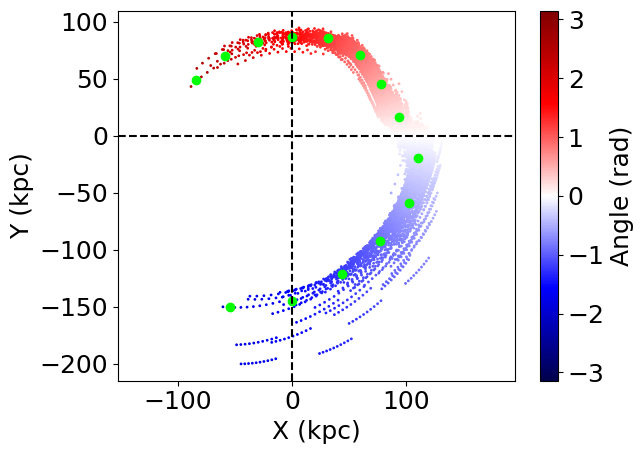

In [235]:
plt.scatter(xv_stream_streak[:, 0], xv_stream_streak[:, 1], c=theta_stream_streak, s=1, cmap='seismic', vmin=-np.pi, vmax=np.pi)
plt.colorbar(label='Angle (rad)')
plt.scatter(r_bin_streak*np.cos(theta_bin_streak), r_bin_streak*np.sin(theta_bin_streak), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

In [251]:
N = 100

seed_r_chi2, r_chi2 = [], []
seed_r_chi, r_chi = [], []

seed_w_chi2, w_chi2 = [], []
seed_w_chi, w_chi = [], []
for i in tqdm(range(N), leave=True):

    with open(f"./MockStreams/seed{i}/dict_stream.pkl", "rb") as f:
        dict_data = pickle.load(f)

    params = dict_data['params']

    theta_stream, xv_stream, theta_sat, xv_sat = generate_stream_streak(params,  seed=111)
    count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])

    r_diff = abs(dict_data['r_bin'] - r_bin)[dict_data['count'] > 100]
    r_bias = (dict_data['r_bin'] - r_bin)[dict_data['count'] > 100]

    w_diff = abs(dict_data['w_bin'] - w_bin)[dict_data['count'] > 100]
    w_bias = (dict_data['w_bin'] - w_bin)[dict_data['count'] > 100]

    r_chi2.extend((r_diff / dict_data['r_bin'][dict_data['count'] > 100]))
    r_chi.extend((r_bias / dict_data['r_bin'][dict_data['count'] > 100]))

    w_chi2.extend((w_diff / dict_data['w_bin'][dict_data['count'] > 100]))
    w_chi.extend((w_bias / dict_data['w_bin'][dict_data['count'] > 100]))

    theta_stream, xv_stream, theta_sat, xv_sat = generate_stream_spray(params,  seed=111+1)
    count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])

    r_diff = abs(dict_data['r_bin'] - r_bin)[dict_data['count'] > 100]
    r_bias = (dict_data['r_bin'] - r_bin)[dict_data['count'] > 100]

    w_diff = abs(dict_data['w_bin'] - w_bin)[dict_data['count'] > 100]
    w_bias = (dict_data['w_bin'] - w_bin)[dict_data['count'] > 100]

    seed_r_chi2.extend((r_diff / dict_data['r_bin'][dict_data['count'] > 100]))
    seed_r_chi.extend((r_bias / dict_data['r_bin'][dict_data['count'] > 100]))

    seed_w_chi2.extend((w_diff / dict_data['w_bin'][dict_data['count'] > 100]))
    seed_w_chi.extend((w_bias / dict_data['w_bin'][dict_data['count'] > 100]))

seed_r_chi2 = jnp.array(seed_r_chi2)
seed_r_chi = jnp.array(seed_r_chi)
r_chi2 = jnp.array(r_chi2)
r_chi = jnp.array(r_chi)

seed_w_chi2 = jnp.array(seed_w_chi2)
seed_w_chi = jnp.array(seed_w_chi)
w_chi2 = jnp.array(w_chi2)
w_chi = jnp.array(w_chi)

100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


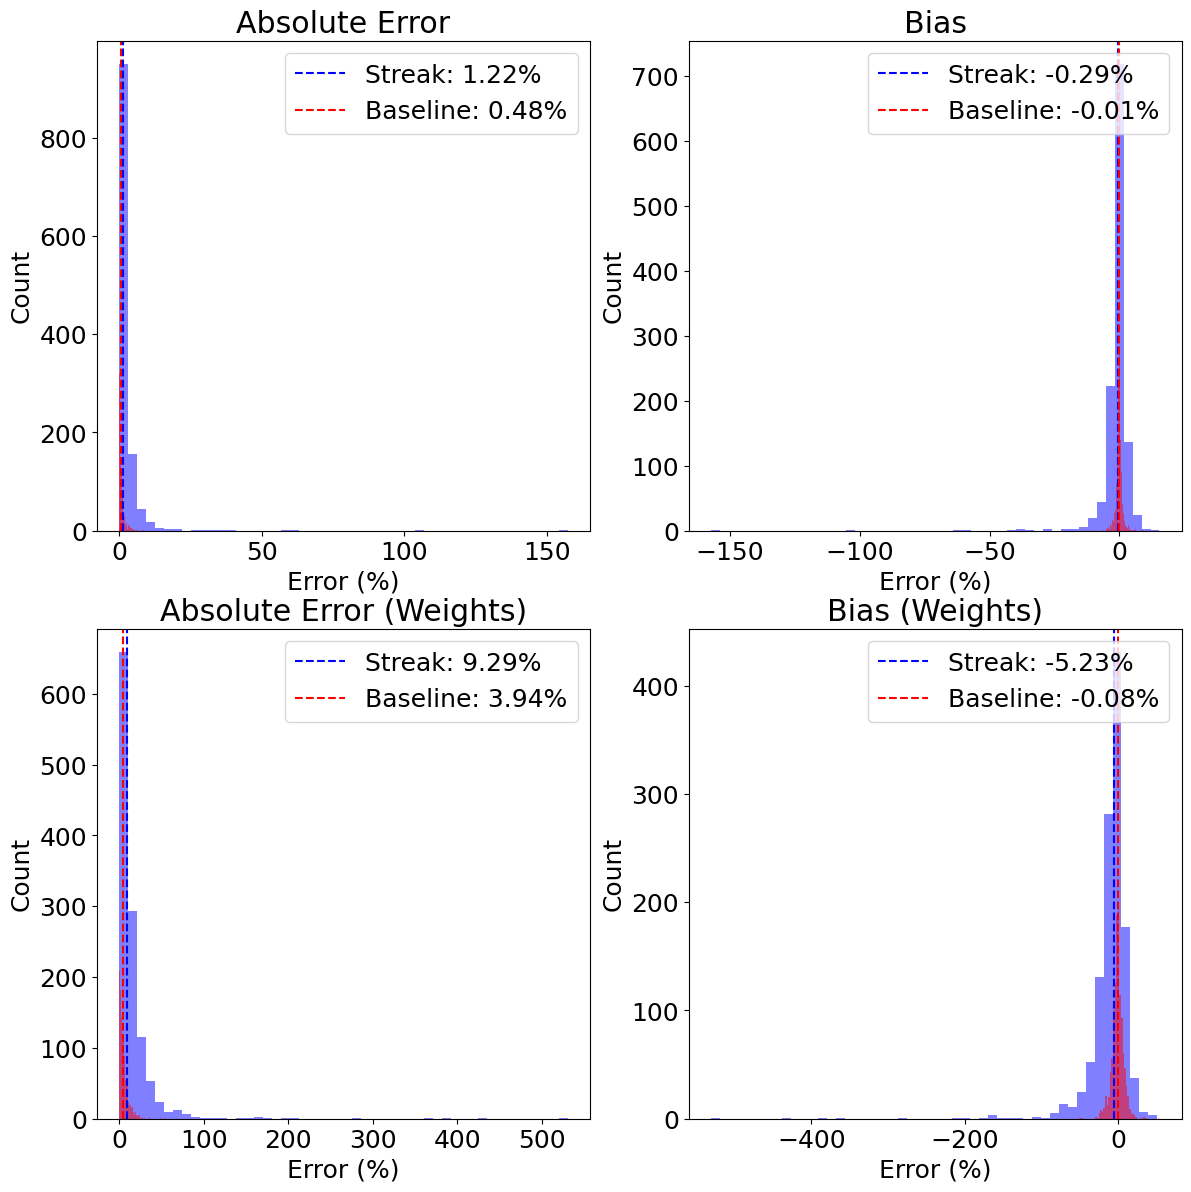

In [252]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
plt.title('Absolute Error')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*r_chi2, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_r_chi2, bins=50, alpha=0.5, color='r')
plt.axvline(np.median(100*r_chi2), color='b', linestyle='--', label=f'Streak: {np.median(100*r_chi2):.2f}%')
plt.axvline(np.median(100*seed_r_chi2), color='r', linestyle='--', label=f'Baseline: {np.median(100*seed_r_chi2):.2f}%')
plt.legend(loc='upper right')

plt.subplot(2, 2, 2)
plt.title('Bias')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*r_chi, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_r_chi, bins=50, alpha=0.5, color='r')
plt.axvline(np.median(100*r_chi), color='b', linestyle='--', label=f'Streak: {np.median(100*r_chi):.2f}%')
plt.axvline(np.median(100*seed_r_chi), color='r', linestyle='--', label=f'Baseline: {np.median(100*seed_r_chi):.2f}%')
plt.legend(loc='upper right')

plt.subplot(2, 2, 3)
plt.title('Absolute Error (Weights)')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*w_chi2, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_w_chi2, bins=50, alpha=0.5, color='r')
plt.axvline(np.median(100*w_chi2), color='b', linestyle='--', label=f'Streak: {np.median(100*w_chi2):.2f}%')
plt.axvline(np.median(100*seed_w_chi2), color='r', linestyle='--', label=f'Baseline: {np.median(100*seed_w_chi2):.2f}%')
plt.legend(loc='upper right')

plt.subplot(2, 2, 4)
plt.title('Bias (Weights)')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*w_chi, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_w_chi, bins=50, alpha=0.5, color='r')
plt.axvline(np.median(100*w_chi), color='b', linestyle='--', label=f'Streak: {np.median(100*w_chi):.2f}%')
plt.axvline(np.median(100*seed_w_chi), color='r', linestyle='--', label=f'Baseline: {np.median(100*seed_w_chi):.2f}%')
plt.legend(loc='upper right')


## (3) 2nd Degree method

In [68]:
%reload_ext autoreload
%autoreload 2

from first import generate_stream_first
from utils import inference_stream
from spray import generate_stream_spray

start = tt.time()
theta_stream_first, xv_stream_first, theta_sat_first, xv_sat_first, S, dS, refs, samples = generate_stream_first(params,  seed=111+1)
theta_samples, xv_samples = inference_stream(theta_stream_first, xv_stream_first, refs, S, seed=111, disp_x=0.3, disp_v=0.3)
end = tt.time()
print(f"Time taken to generate stream using First: {end - start:.2f} seconds")
count_first, theta_bin_first, r_bin_first, w_bin_first = get_track(theta_samples, xv_samples[:, 0], xv_samples[:, 1])

Time taken to generate stream using First: 0.06 seconds


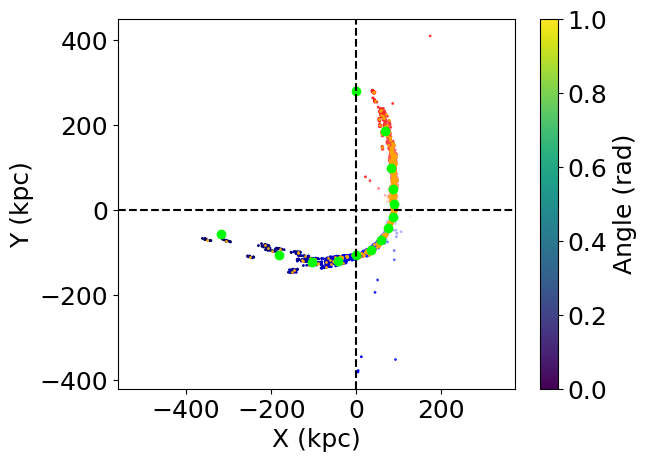

In [69]:
plt.scatter(xv_samples[:, 0], xv_samples[:, 1], c=theta_samples, s=1, cmap='seismic', vmin=-np.pi, vmax=np.pi)
plt.scatter(xv_stream_first[:, 0], xv_stream_first[:, 1], c='orange', s=1)
plt.colorbar(label='Angle (rad)')
plt.scatter(r_bin_first*np.cos(theta_bin_first), r_bin_first*np.sin(theta_bin_first), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

In [70]:
N = 100

seed_r_chi2, r_chi2 = [], []
seed_r_chi, r_chi = [], []

seed_w_chi2, w_chi2 = [], []
seed_w_chi, w_chi = [], []
for i in tqdm(range(N), leave=True):

    with open(f"./MockStreams/seed{i}/dict_stream.pkl", "rb") as f:
        dict_data = pickle.load(f)

    params = dict_data['params']

    theta_stream_first, xv_stream_first, theta_sat_first, xv_sat_first, S, dS, refs, samples = generate_stream_first(params,  seed=111+3)
    theta_samples, xv_samples = inference_stream(theta_stream_first, xv_stream_first, refs, S, seed=111+3, disp_x=0.1, disp_v=0.1)
    count_first, theta_bin_first, r_bin, w_bin = get_track(theta_samples, xv_samples[:, 0], xv_samples[:, 1])

    r_diff = abs(dict_data['r_bin'] - r_bin)[dict_data['count'] > 100]
    r_bias = (dict_data['r_bin'] - r_bin)[dict_data['count'] > 100]

    w_diff = abs(dict_data['w_bin'] - w_bin)[dict_data['count'] > 100]
    w_bias = (dict_data['w_bin'] - w_bin)[dict_data['count'] > 100]

    r_chi2.extend((r_diff / dict_data['r_bin'][dict_data['count'] > 100]))
    r_chi.extend((r_bias / dict_data['r_bin'][dict_data['count'] > 100]))

    w_chi2.extend((w_diff / dict_data['w_bin'][dict_data['count'] > 100]))
    w_chi.extend((w_bias / dict_data['w_bin'][dict_data['count'] > 100]))

    theta_stream, xv_stream, theta_sat, xv_sat = generate_stream_spray(params,  seed=111+3)
    count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])
    min_count = 10

    r_diff = abs(dict_data['r_bin'] - r_bin)[dict_data['count'] > min_count]
    r_bias = (dict_data['r_bin'] - r_bin)[dict_data['count'] > min_count]

    w_diff = abs(dict_data['w_bin'] - w_bin)[dict_data['count'] > min_count]
    w_bias = (dict_data['w_bin'] - w_bin)[dict_data['count'] > min_count]

    seed_r_chi2.extend((r_diff / dict_data['r_bin'][dict_data['count'] > min_count]))
    seed_r_chi.extend((r_bias / dict_data['r_bin'][dict_data['count'] > min_count]))

    seed_w_chi2.extend((w_diff / dict_data['w_bin'][dict_data['count'] > min_count]))
    seed_w_chi.extend((w_bias / dict_data['w_bin'][dict_data['count'] > min_count]))

seed_r_chi2 = jnp.array(seed_r_chi2)
seed_r_chi = jnp.array(seed_r_chi)
r_chi2 = jnp.array(r_chi2)
r_chi = jnp.array(r_chi)

seed_w_chi2 = jnp.array(seed_w_chi2)
seed_w_chi = jnp.array(seed_w_chi)
w_chi2 = jnp.array(w_chi2)
w_chi = jnp.array(w_chi)

100%|██████████| 100/100 [01:25<00:00,  1.16it/s]


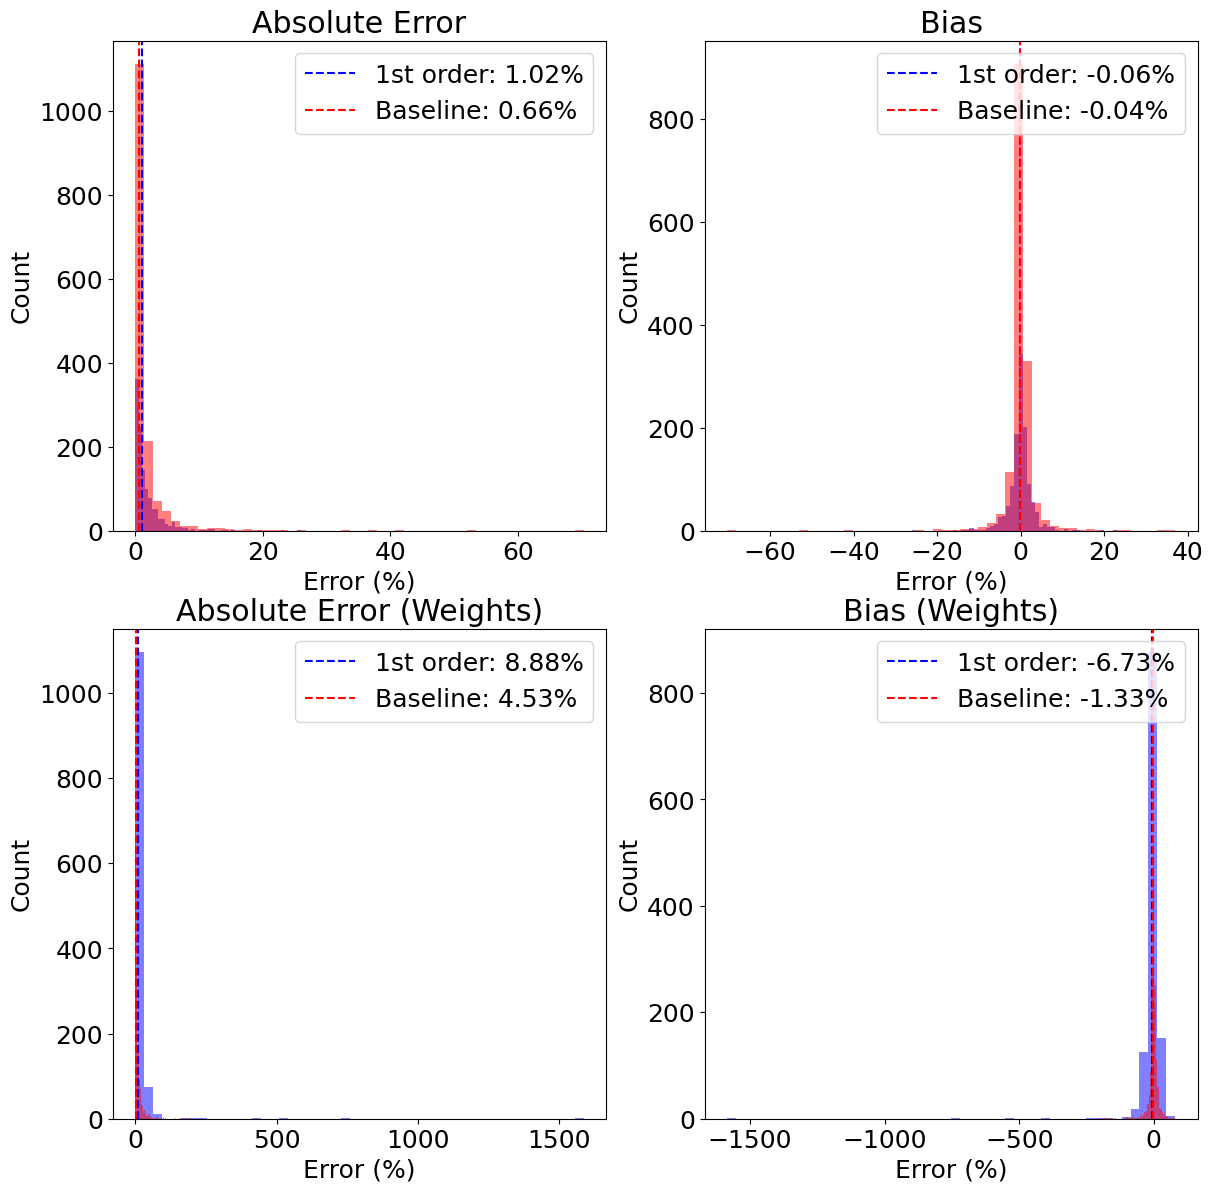

In [71]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
plt.title('Absolute Error')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*r_chi2, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_r_chi2, bins=50, alpha=0.5, color='r')
plt.axvline(np.median(100*r_chi2), color='b', linestyle='--', label=f'1st order: {np.median(100*r_chi2):.2f}%')
plt.axvline(np.median(100*seed_r_chi2), color='r', linestyle='--', label=f'Baseline: {np.median(100*seed_r_chi2):.2f}%')
plt.legend(loc='upper right')

plt.subplot(2, 2, 2)
plt.title('Bias')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*r_chi, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_r_chi, bins=50, alpha=0.5, color='r')
plt.axvline(np.mean(100*r_chi), color='b', linestyle='--', label=f'1st order: {np.mean(100*r_chi):.2f}%')
plt.axvline(np.mean(100*seed_r_chi), color='r', linestyle='--', label=f'Baseline: {np.mean(100*seed_r_chi):.2f}%')
plt.legend(loc='upper right')

plt.subplot(2, 2, 3)
plt.title('Absolute Error (Weights)')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*w_chi2, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_w_chi2, bins=50, alpha=0.5, color='r')
plt.axvline(np.median(100*w_chi2), color='b', linestyle='--', label=f'1st order: {np.median(100*w_chi2):.2f}%')
plt.axvline(np.median(100*seed_w_chi2), color='r', linestyle='--', label=f'Baseline: {np.median(100*seed_w_chi2):.2f}%')
plt.legend(loc='upper right')

plt.subplot(2, 2, 4)
plt.title('Bias (Weights)')
plt.ylabel('Count')
plt.xlabel('Error (%)')
plt.hist(100*w_chi, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_w_chi, bins=50, alpha=0.5, color='r')
plt.axvline(np.mean(100*w_chi), color='b', linestyle='--', label=f'1st order: {np.mean(100*w_chi):.2f}%')
plt.axvline(np.mean(100*seed_w_chi), color='r', linestyle='--', label=f'Baseline: {np.mean(100*seed_w_chi):.2f}%')
plt.legend(loc='upper right')
